/Users/christianbasile/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/christianbasile/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


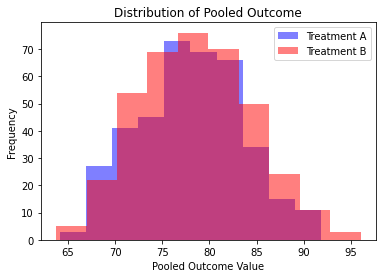

                           sum_sq     df           F        PR(>F)
Treatment               92.366569    1.0    3.969566  4.668562e-02
Age                   4265.363683    1.0  183.309197  1.383970e-37
StressLevel            295.888828    1.0   12.716183  3.851011e-04
MentalWellnessScore   2924.099451    1.0  125.666734  4.179513e-27
Residual             17754.005511  763.0         NaN           NaN

For the Pooled Outcome to achieve 80% power using ANCOVA: Required sample size per group is approximately 294538


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import FTestAnovaPower

# Simulate Data
np.random.seed(42)
n_per_group = 384
k = 2  # Number of groups (2 treatments)
subjects = list(range(n_per_group * 2))
treatments = ["A"] * n_per_group + ["B"] * n_per_group

mean_outcomes_A = [50, 55, 60, 65]
mean_outcomes_B = [52, 57, 59, 63]
std_dev = 10

covariate_age = np.random.normal(30, 5, n_per_group * 2)
covariate_stress = np.random.uniform(1, 10, n_per_group * 2)  # On a scale of 1 to 10
covariate_mental_wellness = np.random.uniform(50, 100, n_per_group * 2)  # Score out of 100

data_list = []

for idx, (mean_a, mean_b) in enumerate(zip(mean_outcomes_A, mean_outcomes_B)):
    outcome_A = np.random.normal(mean_a + 0.5 * covariate_age[:n_per_group] - 0.3 * covariate_stress[:n_per_group] + 0.1 * covariate_mental_wellness[:n_per_group], std_dev, n_per_group)
    outcome_B = np.random.normal(mean_b + 0.5 * covariate_age[n_per_group:] - 0.3 * covariate_stress[n_per_group:] + 0.1 * covariate_mental_wellness[n_per_group:], std_dev, n_per_group)
    data = pd.DataFrame({
        'Subject': subjects,
        'Treatment': treatments,
        'Age': covariate_age,
        'StressLevel': covariate_stress,
        'MentalWellnessScore': covariate_mental_wellness,
        f'Outcome_{idx + 1}': list(outcome_A) + list(outcome_B)
    })
    data_list.append(data)

data_merged = data_list[0]
for df in data_list[1:]:
    data_merged = pd.merge(data_merged, df, on=['Subject', 'Treatment', 'Age', 'StressLevel', 'MentalWellnessScore'])

# Pool Outcomes
data_merged['Pooled_Outcome'] = data_merged[['Outcome_1', 'Outcome_2', 'Outcome_3', 'Outcome_4']].mean(axis=1)

# Plot distributions of pooled outcomes
plt.hist(data_merged[data_merged['Treatment'] == 'A']['Pooled_Outcome'], alpha=0.5, label='Treatment A', color='blue')
plt.hist(data_merged[data_merged['Treatment'] == 'B']['Pooled_Outcome'], alpha=0.5, label='Treatment B', color='red')
plt.legend()
plt.title('Distribution of Pooled Outcome')
plt.xlabel('Pooled Outcome Value')
plt.ylabel('Frequency')
plt.show()

# ANCOVA
model = ols('Pooled_Outcome ~ Treatment + Age + StressLevel + MentalWellnessScore', data=data_merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Power Analysis
f_value = anova_table.loc['Treatment', 'F']
n_total = n_per_group * k
eta_squared = f_value / (f_value + (n_total - k - 1))
power_analysis = FTestAnovaPower()
required_n = power_analysis.solve_power(effect_size=eta_squared, alpha=0.05, power=0.80, k_groups=k)
print(f"\nFor the Pooled Outcome to achieve 80% power using ANCOVA: Required sample size per group is approximately {int(np.ceil(required_n))}")
